# LUPI-SKD Test Notebook

## 목적
- Teacher/Student 입력 비대칭 (Q vs Q+K) 테스트
- LUPI rollout 함수 검증
- Loss 계산 정확성 확인

## 핵심
- **Teacher**: Q + K (privileged knowledge)
- **Student**: Q only
- **Loss**: KL(Student(Q+Y) || Teacher(Q+K+Y))

In [ ]:
# Cell 1: Import 및 환경 설정
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7"

# Project root 설정
PROJECT_ROOT = os.path.dirname(os.getcwd())
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from train.lupi_rollout import lupi_skd_rollout_block

# Device 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"Project root: {PROJECT_ROOT}")

# 재현성을 위한 seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [2]:
# Cell 2: 모델 및 토크나이저 로드 (Qwen3 패밀리)

# Qwen3 모델 설정
student_model_name = "Qwen/Qwen3-4B-Thinking-2507"  # Teacher
teacher_model_name = "Qwen/Qwen3-32B"                # Student

print(f"Loading Teacher: {teacher_model_name}")
print(f"Loading Student: {student_model_name}")

tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
tokenizer.pad_token = tokenizer.eos_token

# Teacher 모델 로드 (Thinking 전용)
teacher_model = AutoModelForCausalLM.from_pretrained(
    teacher_model_name,
    torch_dtype=torch.bfloat16,  # 메모리 효율
    device_map="auto",
    attn_implementation="flash_attention_2",
).eval()

# Student 모델 로드
student_model = AutoModelForCausalLM.from_pretrained(
    student_model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2",
).eval()

print(f"✓ Models loaded")
print(f"  Teacher params: {sum(p.numel() for p in teacher_model.parameters())/1e9:.2f}B")
print(f"  Student params: {sum(p.numel() for p in student_model.parameters())/1e9:.2f}B")
print(f"  Teacher device: {teacher_model.device}")
print(f"  Student device: {student_model.device}")



Loading Teacher: Qwen/Qwen3-32B
Loading Student: Qwen/Qwen3-4B-Thinking-2507


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


✓ Models loaded
  Teacher params: 32.76B
  Student params: 4.02B
  Teacher device: cuda:0
  Student device: cuda:0


In [3]:
# Cell 3: 한국 문화 샘플 데이터 준비

# 한국 문화 쿼리 3개 구성
korean_culture_samples = [
    {
        "query": "설날에 세배를 드릴 때 어떤 예절을 지켜야 하나요?",
        "knowledge": "설날 세배는 윗어른께 새해 인사를 드리는 전통 예절입니다. 남자는 큰절(평절), 여자는 반절을 하며, 절을 할 때는 '새해 복 많이 받으세요'라고 인사합니다. 세배를 받은 어른은 덕담과 함께 세배돈(세뱃돈)을 주는 것이 관습입니다. 절을 할 때는 공손한 자세로 두 손을 모으고, 허리를 깊이 숙여야 합니다.",
    },
    {
        "query": "한복을 입을 때 지켜야 할 예절이나 규칙이 있나요?",
        "knowledge": "한복 착용 시에는 여러 예절이 있습니다. 여성 한복의 경우 저고리 고름은 오른쪽이 위로 오도록 맞깃으로 여미고, 치마는 가슴 위까지 올려 입습니다. 남성 한복은 바지저고리를 먼저 입은 후 조끼나 두루마기를 덧입습니다. 색상은 미혼 여성은 밝은 색, 기혼 여성은 은은한 색을 선호하며, 상황에 따라 예복용과 평상복용을 구분합니다.",
    },
    {
        "query": "김장은 언제 하는 것이 좋고, 왜 중요한 문화인가요?",
        "knowledge": "김장은 보통 입동(11월 7~8일경) 이후 첫 추위가 찾아올 때 담그는 것이 전통입니다. 기온이 영하로 떨어지기 전, 배추가 얼지 않을 정도의 서늘한 날씨(5~10도)가 김치 발효에 가장 적합합니다. 김장은 겨울철 비타민 공급원을 확보하는 중요한 월동 준비 문화였으며, 이웃과 나누는 '김장 나눔' 문화는 공동체 정신을 상징합니다. 2013년 유네스코 인류무형문화유산으로 등재되었습니다.",
    },
]

def build_lupi_inputs(query: str, knowledge: str):
    """Return (teacher_inputs, student_inputs) for a single LUPI sample."""
    teacher_messages = [
        {"role": "system", "content": knowledge},
        {"role": "user", "content": query},
    ]
    student_messages = [
        {"role": "user", "content": query},
    ]

    teacher_inputs = tokenizer.apply_chat_template(
        teacher_messages,
        return_dict=True,
        tokenize=True,
        return_tensors="pt",
        add_generation_prompt=True,
        enable_thinking=True,
    )
    student_inputs = tokenizer.apply_chat_template(
        student_messages,
        return_dict=True,
        tokenize=True,
        return_tensors="pt",
        add_generation_prompt=True,
        enable_thinking=True,
    )
    return teacher_inputs, student_inputs

# 테스트할 예시 선택 (0, 1, 2 중 선택)
sample_idx = 0
query = korean_culture_samples[sample_idx]["query"]
knowledge = korean_culture_samples[sample_idx]["knowledge"]

print(f"[예시 {sample_idx + 1}/3 선택]\n")
print("[Query (Q)]")
print(query)
print("\n[Knowledge (K) - Teacher only]")
print(knowledge)

teacher_inputs, student_inputs = build_lupi_inputs(query, knowledge)

print("\n[Input Shapes]")
print(f"  Teacher input: {teacher_inputs['input_ids'].shape} tokens")
print(f"  Student input: {student_inputs['input_ids'].shape} tokens")
print(f"  Difference (K length): {teacher_inputs['input_ids'].shape[1] - student_inputs['input_ids'].shape[1]} tokens")

print("\n[Teacher Input Decoded]")
print(tokenizer.decode(teacher_inputs['input_ids'][0]))
print("\n[Student Input Decoded]")
print(tokenizer.decode(student_inputs['input_ids'][0]))


[예시 1/3 선택]

[Query (Q)]
설날에 세배를 드릴 때 어떤 예절을 지켜야 하나요?

[Knowledge (K) - Teacher only]
설날 세배는 윗어른께 새해 인사를 드리는 전통 예절입니다. 남자는 큰절(평절), 여자는 반절을 하며, 절을 할 때는 '새해 복 많이 받으세요'라고 인사합니다. 세배를 받은 어른은 덕담과 함께 세배돈(세뱃돈)을 주는 것이 관습입니다. 절을 할 때는 공손한 자세로 두 손을 모으고, 허리를 깊이 숙여야 합니다.

[Input Shapes]
  Teacher input: torch.Size([1, 155]) tokens
  Student input: torch.Size([1, 28]) tokens
  Difference (K length): 127 tokens

[Teacher Input Decoded]
<|im_start|>system
설날 세배는 윗어른께 새해 인사를 드리는 전통 예절입니다. 남자는 큰절(평절), 여자는 반절을 하며, 절을 할 때는 '새해 복 많이 받으세요'라고 인사합니다. 세배를 받은 어른은 덕담과 함께 세배돈(세뱃돈)을 주는 것이 관습입니다. 절을 할 때는 공손한 자세로 두 손을 모으고, 허리를 깊이 숙여야 합니다.<|im_end|>
<|im_start|>user
설날에 세배를 드릴 때 어떤 예절을 지켜야 하나요?<|im_end|>
<|im_start|>assistant


[Student Input Decoded]
<|im_start|>user
설날에 세배를 드릴 때 어떤 예절을 지켜야 하나요?<|im_end|>
<|im_start|>assistant



In [ ]:
# Cell 4: LUPI Rollout 실행 (SKD 기본 설정 + 블록 speculative)

print("=" * 60)
print("Running LUPI-SKD Rollout (Block Speculative, LUPI)...")
print("=" * 60)

# === SKD 기본 하이퍼파라미터 설정 ===
max_new_tokens = 4096          # 필요에 따라 512/2048 등으로 조정
top_k = 5                     # 논문/코드 기본값
gamma = 5                      # 블록 크기 (draft 토큰 수)
teacher_temperature = 0.2      # 교사: 날카로운 분포
student_temperature = 0.5      # 학생: 적당한 탐색
teacher_top_p = 0.95            # 교사 top-p
student_top_p = 0.95           # 학생 top-p

print("[SKD Hyperparameters]")
print(f"  max_new_tokens     : {max_new_tokens}")
print(f"  top_k (K)          : {top_k}")
print(f"  gamma (block size) : {gamma}")
print(f"  teacher_temp       : {teacher_temperature}")
print(f"  student_temp       : {student_temperature}")
print(f"  teacher_top_p      : {teacher_top_p}")
print(f"  student_top_p      : {student_top_p}")

# === LUPI-SKD Block Rollout 실행 ===
teacher_full_ids, student_full_ids, generated_tokens, new_str = lupi_skd_rollout_block(
    teacher_model=teacher_model,
    student_model=student_model,
    teacher_input_ids=teacher_inputs["input_ids"],   # Q+K
    student_input_ids=student_inputs["input_ids"],   # Q
    max_new_tokens=max_new_tokens,
    top_k=top_k,
    gamma=gamma,
    teacher_temperature=teacher_temperature,
    student_temperature=student_temperature,
    teacher_top_p=teacher_top_p,
    student_top_p=student_top_p,
    tokenizer=tokenizer,
    end_of_string_ls=None,  # EOS까지 생성
    verbose=True,
    print_every_blocks=5,
)

# === 결과 요약 출력 ===
print("\n[Rollout Results]")
print(f"  Generated tokens      : {len(generated_tokens)}")
print(f"  Teacher full length   : {teacher_full_ids.shape[1]} tokens")
print(f"  Student full length   : {student_full_ids.shape[1]} tokens")

print("\n[Generated Text (Raw, first 1000 chars)]")
print(new_str[:1000])

# === Qwen3 Thinking 블록 파싱 (선택) ===
if "</think>" in new_str:
    think_end_idx = new_str.find("</think>")
    think_start_idx = new_str.find("<think>")

    if think_start_idx >= 0:
        think_content = new_str[think_start_idx + len("<think>") : think_end_idx].strip()
    else:
        think_content = new_str[:think_end_idx].strip()

    final_answer = new_str[think_end_idx + len("</think>") :].strip()

    print("\n[Thinking Process (first 500 chars)]")
    if len(think_content) > 500:
        print(think_content[:500] + "...")
    else:
        print(think_content)

    print("\n[Final Answer]")
    print(final_answer)
else:
    print("\n[Note] No </think> detected - showing first 500 chars of full output")
    print(new_str[:500])

# === LUPI 조건 검증: (Q+K 길이) vs (최종 길이 차이) ===
k_len = teacher_inputs["input_ids"].shape[1] - student_inputs["input_ids"].shape[1]
full_diff = teacher_full_ids.shape[1] - student_full_ids.shape[1]

print("\n[Verification: LUPI Structure]")
print(f"  K length (|Q+K| - |Q|)           : {k_len} tokens")
print(f"  Full sequence diff (T_t - T_s)   : {full_diff} tokens")

if k_len == full_diff:
    print("  ✓ LUPI preserved: Teacher = Q+K+Y, Student = Q+Y")
else:
    print(f"  ⚠ LUPI NOT preserved: {k_len} != {full_diff}")


Running LUPI-SKD Rollout (Block Speculative, LUPI)...
[SKD Hyperparameters]
  max_new_tokens     : 128
  top_k (K)          : 10
  gamma (block size) : 5
  teacher_temp       : 0.2
  student_temp       : 0.5
  teacher_top_p      : 0.95
  student_top_p      : 0.95
[Block 5] total_generated=16
  ...<think>
Okay, so I need to figure out the etiquette for giving a New
----------------------------------------
[Block 5] total_generated=16
  ...<think>
Okay, so I need to figure out the etiquette for giving a New
----------------------------------------
[Block 5] total_generated=16
  ...<think>
Okay, so I need to figure out the etiquette for giving a New
----------------------------------------
[Block 5] total_generated=16
  ...<think>
Okay, so I need to figure out the etiquette for giving a New
----------------------------------------
[Block 5] total_generated=16
  ...<think>
Okay, so I need to figure out the etiquette for giving a New
----------------------------------------
[Block 10] total

In [5]:

# Cell 5: Loss 계산 및 검증 (정렬 보정 + gradient-friendly)

def _extract_generation_logits(logits, prompt_len):
    """Causal LM logits -> generation token logits aligned with outputs."""
    if prompt_len < 1:
        raise ValueError('prompt_len must be >= 1')
    # 위치 t의 로짓이 토큰 t+1을 예측하므로, 마지막 한 칸을 제외하고 사용
    return logits[:, prompt_len - 1:-1, :]

def compute_lupi_kl_loss(
    teacher_model,
    student_model,
    teacher_full_ids,
    student_full_ids,
    teacher_inputs,
    student_inputs,
    reduction='batchmean',
):
    """Returns KL loss + per-token values with gradients flowing to the student."""
    teacher_model.eval()

    with torch.no_grad():
        teacher_outputs = teacher_model(
            input_ids=teacher_full_ids.to(device),
            attention_mask=torch.ones_like(teacher_full_ids).to(device),
        )

    student_outputs = student_model(
        input_ids=student_full_ids.to(device),
        attention_mask=torch.ones_like(student_full_ids).to(device),
    )

    teacher_logits = _extract_generation_logits(
        teacher_outputs.logits, teacher_inputs.input_ids.shape[1]
    )
    student_logits = _extract_generation_logits(
        student_outputs.logits, student_inputs.input_ids.shape[1]
    )

    gen_len = min(teacher_logits.shape[1], student_logits.shape[1])
    teacher_logps = teacher_logits[:, :gen_len, :].log_softmax(dim=-1).detach()
    student_logps = student_logits[:, :gen_len, :].log_softmax(dim=-1)

    kl_loss = F.kl_div(student_logps, teacher_logps, reduction=reduction, log_target=True)

    per_token_kl = (
        F.kl_div(student_logps, teacher_logps, reduction='none', log_target=True)
        .sum(dim=-1)[0]
        .detach()
        .cpu()
        .tolist()
    )
    return kl_loss, per_token_kl, gen_len

kl_loss_before, token_kl_before, used_gen_len = compute_lupi_kl_loss(
    teacher_model,
    student_model,
    teacher_full_ids,
    student_full_ids,
    teacher_inputs,
    student_inputs,
)

print("=" * 60)
print("Computing LUPI Loss (teacher vs student logits aligned)...")
print("=" * 60)
print(f"  Teacher input length : {teacher_inputs.input_ids.shape[1]}")
print(f"  Student input length : {student_inputs.input_ids.shape[1]}")
print(f"  Generation length    : {used_gen_len}")
print(f"  KL Divergence        : {kl_loss_before.item():.6f}")

print("[Per-token KL (first 10)]")
for i, kl in enumerate(token_kl_before[:10]):
    token_text = tokenizer.decode([generated_tokens[i]]) if i < len(generated_tokens) else '<pad>'
    print(f"  Token {i:02d}: '{token_text}' -> KL = {kl:.6f}")



Computing LUPI Loss (teacher vs student logits aligned)...
  Teacher input length : 155
  Student input length : 28
  Generation length    : 132
  KL Divergence        : 270.000000
[Per-token KL (first 10)]
  Token 00: '<think>' -> KL = 0.000012
  Token 01: '
' -> KL = 0.000189
  Token 02: 'Okay' -> KL = 0.184570
  Token 03: ',' -> KL = 0.000022
  Token 04: ' so' -> KL = 0.894531
  Token 05: ' I' -> KL = 1.007812
  Token 06: ' need' -> KL = 0.000797
  Token 07: ' to' -> KL = 0.000012
  Token 08: ' figure' -> KL = 3.921875
  Token 09: ' out' -> KL = 0.000025


In [ ]:
# Utility: 학생 답변 생성 함수 (prompt 제외)

def generate_student_response(
    student_inputs,
    model=student_model,
    *,
    max_new_tokens,
    temperature=0.7,
    top_p=0.9,
):
    """Return (generated_ids, decoded_generation)."""
    was_training = model.training
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=student_inputs['input_ids'].to(device),
            attention_mask=torch.ones_like(student_inputs['input_ids']).to(device),
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            eos_token_id=tokenizer.eos_token_id,
        )
    prompt_len = student_inputs['input_ids'].shape[1]
    gen_text = tokenizer.decode(generated_ids[0][prompt_len:], skip_special_tokens=True)
    if was_training:
        model.train()
    return generated_ids, gen_text


In [6]:
# Cell 6: 학생 모델 응답 (훈련 전 스냅샷)

_, student_pre_text = generate_student_response(
    student_inputs,
    model=student_model,
    max_new_tokens=max_new_tokens,
    temperature=0.7,
    top_p=0.9,
)
print('=' * 60)
print('학생 모델 출력 (훈련 전)')
print('=' * 60)
print(student_pre_text)


학생 모델 출력 (훈련 전)
user
설날에 세배를 드릴 때 어떤 예절을 지켜야 하나요?
assistant
<think>
Okay, so I need to figure out the proper etiquette for giving three wishes (세배) on Spring Festival (설날). Wait, first I should clarify what "세배" means here. In Korean, "세배" usually means "thank you" (like "thank you very much"), but sometimes it can be a term for a bow or a gesture. Wait, no, maybe the user is confused. Wait, in Korean, "세배" is a term of thanks, like "thank you" in a formal way, but in the context of 설날 (Korean New Year), maybe they're


In [ ]:

# Cell 7: SKD KL Loss Backprop (단일 스텝 예시)

from torch.optim import AdamW

student_model.train()
optimizer = AdamW(student_model.parameters(), lr=5e-6)
optimizer.zero_grad()

kl_loss_train, _, _ = compute_lupi_kl_loss(
    teacher_model,
    student_model,
    teacher_full_ids,
    student_full_ids,
    teacher_inputs,
    student_inputs,
)
print(f"[Forward] KL loss = {kl_loss_train.item():.6f}")

kl_loss_train.backward()
torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
optimizer.step()
student_model.eval()

kl_loss_after, token_kl_after, used_len_after = compute_lupi_kl_loss(
    teacher_model,
    student_model,
    teacher_full_ids,
    student_full_ids,
    teacher_inputs,
    student_inputs,
)
print(f"[Post-Update] KL loss = {kl_loss_after.item():.6f}")



[Forward] KL loss = 270.000000
[Post-Update] KL loss = 190.000000


In [ ]:
# Cell 8: 학생 모델 응답 (훈련 후) 및 비교

_, student_post_text = generate_student_response(
    student_inputs,
    model=student_model,
    max_new_tokens=max_new_tokens,
    temperature=0.7,
    top_p=0.9,
)

print('=' * 60)
print('학생 모델 출력 (훈련 후)')
print('=' * 60)
print(student_post_text)

print('[비교: 훈련 전 vs 후]')
print('- Before (학생)')
print(student_pre_text)
print('- After (학생)')
print(student_post_text)


학생 모델 출력 (훈련 후)
user
설날에 세배를 드릴 때 어떤 예절을 지켜야 하나요?
assistant
<think>
Okay, so I need to figure out the proper etiquette for giving a threefold bow (세배) on Chinese New Year. Wait, no, the user mentioned "설날" which is Korean New Year, not Chinese. So it's about Korean New Year's Day, which is called Seollal. And they want to know the etiquette when giving a threefold bow.

First, I should recall what a 세배 (threefold bow) is in Korean culture. In Korean etiquette, especially during holidays like Seollal, there are specific ways to greet and show respect. The threefold bow is a traditional way
[Diff: Before vs After]
--- before
+++ after
@@ -2,4 +2,6 @@
 설날에 세배를 드릴 때 어떤 예절을 지켜야 하나요?
 assistant
 <think>
-Okay, so I need to figure out the proper etiquette for giving three wishes (세배) on Spring Festival (설날). Wait, first I should clarify what "세배" means here. In Korean, "세배" usually means "thank you" (like "thank you very much"), but sometimes it can be a term for a bow or a gesture. Wait, no,

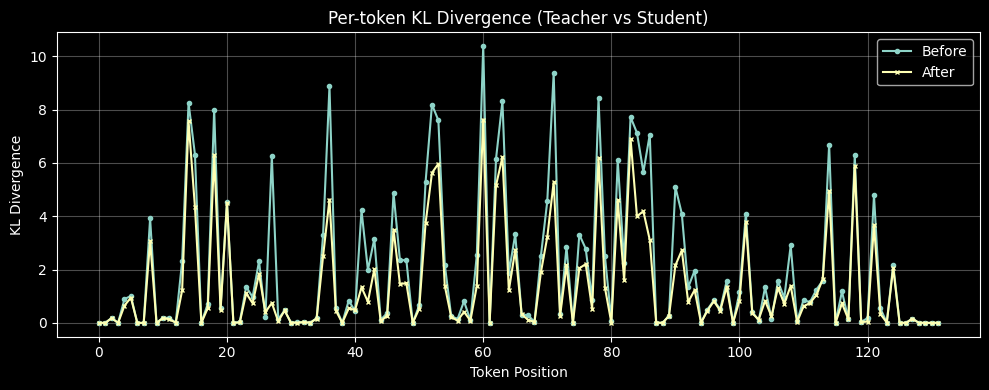

✓ Saved visualization to lupi_token_kl_compare.png


In [9]:

# Cell 9: KL 시각화 (Before vs After)

import matplotlib.pyplot as plt
import numpy as np

if 'token_kl_after' not in globals():
    raise RuntimeError('Run the training cell first to compute token_kl_after.')

plt.figure(figsize=(10, 4))
plt.plot(token_kl_before, label='Before', marker='o', markersize=3)
plt.plot(token_kl_after, label='After', marker='x', markersize=3)
plt.xlabel('Token Position')
plt.ylabel('KL Divergence')
plt.title('Per-token KL Divergence (Teacher vs Student)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('lupi_token_kl_compare.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved visualization to lupi_token_kl_compare.png')



In [ ]:
# Cell 12: 테스트 쿼리 정의 (일반화 확인)

test_query_sample = {
    'query': '설날에 한복을 단정히 입고 조상님께 세배 올릴 때 준비 순서와 덕담 예절을 모두 알려줘.',
    'knowledge': '설날 아침에는 먼저 맑은 물로 세수하고 마음가짐을 다진 뒤 한복을 정갈하게 갖춰 입는다. 여성은 저고리 고름을 오른쪽이 위로 가게 맞깃으로 묶고 치마를 가슴 위까지 올려 단단히 여미며, 남성은 바지저고리를 입고 조끼나 두루마기를 덧입는다. 세배는 어른 앞에서 두 손을 모아 큰절(남) 혹은 반절(여)로 허리를 깊게 숙여 올리고, 절하기 전에 “새해 복 많이 받으세요”라고 인사한 뒤 덕담에는 건강·학업·가정의 화목을 비는 말을 담는다.',
}
test_teacher_inputs, test_student_inputs = build_lupi_inputs(
    test_query_sample['query'],
    test_query_sample['knowledge'],
)
print('[테스트 Query]')
print(test_query_sample['query'])
print('Privileged Knowledge]')
print(test_query_sample['knowledge'])


In [ ]:
# Cell 13: 테스트 쿼리 - 학습 전 학생 응답

_, test_student_pre_text = generate_student_response(
    test_student_inputs,
    model=student_model,
    max_new_tokens=max_new_tokens,
    temperature=0.7,
    top_p=0.9,
)
print('[학생 출력 - 학습 전]')
print(test_student_pre_text)


In [ ]:
# Cell 14: 3개 샘플 × 5 epoch LUPI-SKD 학습

from torch.optim import AdamW

epochs = 5
train_logs = []
optimizer = AdamW(student_model.parameters(), lr=5e-6, weight_decay=0.01)

student_model.train()
for epoch in range(1, epochs + 1):
    epoch_losses = []
    for sample_i, sample in enumerate(korean_culture_samples):
        teacher_inputs_i, student_inputs_i = build_lupi_inputs(sample['query'], sample['knowledge'])
        teacher_full_ids_i, student_full_ids_i, gen_tokens_i, _ = lupi_skd_rollout_block(
            teacher_model=teacher_model,
            student_model=student_model,
            teacher_input_ids=teacher_inputs_i['input_ids'],
            student_input_ids=student_inputs_i['input_ids'],
            max_new_tokens=max_new_tokens,
            top_k=top_k,
            gamma=gamma,
            teacher_temperature=teacher_temperature,
            student_temperature=student_temperature,
            teacher_top_p=teacher_top_p,
            student_top_p=student_top_p,
            tokenizer=tokenizer,
            end_of_string_ls=None,
            verbose=False,
        )
        kl_loss_i, _, _ = compute_lupi_kl_loss(
            teacher_model,
            student_model,
            teacher_full_ids_i,
            student_full_ids_i,
            teacher_inputs_i,
            student_inputs_i,
        )
        optimizer.zero_grad()
        kl_loss_i.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
        optimizer.step()

        epoch_losses.append(kl_loss_i.item())
        train_logs.append({
            'epoch': epoch,
            'sample_idx': sample_i,
            'query': sample['query'],
            'kl_loss': float(kl_loss_i.item()),
            'tokens': len(gen_tokens_i),
        })
        print(f"[Epoch {epoch} | Sample {sample_i + 1}] KL = {kl_loss_i.item():.4f} (tokens={len(gen_tokens_i)})")

    mean_loss = sum(epoch_losses) / max(len(epoch_losses), 1)
    print(f"[Epoch {epoch}] Mean KL = {mean_loss:.4f}")

student_model.eval()


In [ ]:
# Cell 15: 테스트 쿼리 - 학습 후 비교

_, test_student_post_text = generate_student_response(
    test_student_inputs,
    model=student_model,
    max_new_tokens=max_new_tokens,
    temperature=0.7,
    top_p=0.9,
)
print('[학생 출력 - 학습 후]')
print(test_student_post_text)

print('[테스트 쿼리: Before vs After]')
print('- Before (학생)')
print(test_student_pre_text)
print('- After (학생)')
print(test_student_post_text)
